## Thresholding for Multi-Task Classification

To execute this notebook, first install the DeepChem library:

    conda create --name deepchem-test
    conda activate deepchem-test
    conda install -y -c conda-forge rdkit nb_conda_kernels matplotlib
    pip3 install tensorflow==2.2.0
    pip3 install --pre deepchem 

#### Libraries and Functions

In [49]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

In [50]:
import os
import numpy as np
import shutil
import deepchem as dc
import matplotlib as mpl
import matplotlib.pyplot as plt



#### GHOST: Function to optimize the decision threshold

In [51]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

def optimize_threshold_from_predictions(labels, probs, thresholds, 
                                    ThOpt_metrics = 'Kappa', N_subsets = 100, 
                                    subsets_size = 0.2, with_replacement = False, random_seed = None):

    """ Optimize the decision threshold based on subsets of the training set.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the training subsets is chosen as optimal.
    
    Parameters
    ----------
    labels: sequence of ints
        True labels for the training set
    probs: sequence of floats
        predicted probabilities for minority class from the training set 
        (e.g. output from cls.predict_proba(data)[:,1])
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
    N_subsets: int
        Number of training subsets to use in the optimization
    subsets_size: float or int
        Size of the subsets. if float, represents the proportion of the dataset to include in the subsets. 
        If integer, it represents the actual number of instances to include in the subsets. 
    with_replacement: bool
        The subsets are drawn randomly. True to draw the subsets with replacement
    random_seed: int    
        random number to seed the drawing of the subsets
    
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """
    # seeding
    np.random.seed(random_seed)
    random_seeds = np.random.randint(N_subsets*10, size=N_subsets)  
    
    df_preds = pd.DataFrame({'labels':labels,'probs':probs})
    thresh_names = [str(x) for x in thresholds]
    for thresh in thresholds:
        df_preds[str(thresh)] = [1 if x>=thresh else 0 for x in probs]
    # Optmize the decision threshold based on the Cohen's Kappa coefficient
    if ThOpt_metrics == 'Kappa':
        # pick N_subsets training subsets and determine the threshold that provides the highest kappa on each 
        # of the subsets
        kappa_accum = []
        for i in range(N_subsets):
            if with_replacement:
                if isinstance(subsets_size, float):
                    Nsamples = int(df_preds.shape[0]*subsets_size)
                elif isinstance(subsets_size, int):
                    Nsamples = subsets_size                    
                df_subset = resample(df_preds, replace=True, n_samples = Nsamples, stratify=labels, random_state = random_seeds[i])
                labels_subset = df_subset['labels']
            else:
                df_tmp, df_subset, labels_tmp, labels_subset = train_test_split(df_preds, labels, test_size = subsets_size, stratify = labels, random_state = random_seeds[i])
            kappa_train_subset = []
            for col1 in thresh_names:
                kappa_train_subset.append(metrics.cohen_kappa_score(labels_subset, list(df_subset[col1])))
            kappa_accum.append(kappa_train_subset)
        # determine the threshold that provides the best results on the training subsets
        y_values_median, y_values_std = helper_calc_median_std(kappa_accum)
        opt_thresh = thresholds[np.argmax(y_values_median)]
    # Optmize the decision threshold based on the ROC-curve, as described here https://doi.org/10.1007/s11548-013-0913-8
    elif ThOpt_metrics == 'ROC':
        sensitivity_accum = []
        specificity_accum = []
        # Calculate sensitivity and specificity for a range of thresholds and N_subsets
        for i in range(N_subsets):
            if with_replacement:
                if isinstance(subsets_size, float):
                    Nsamples = int(df_preds.shape[0]*subsets_size)
                elif isinstance(subsets_size, int):
                    Nsamples = subsets_size                    
                df_subset = resample(df_preds, n_samples = Nsamples, stratify=labels, random_state = random_seeds[i])
                labels_subset = list(df_subset['labels'])
            else:
                df_tmp, df_subset, labels_tmp, labels_subset = train_test_split(df_preds, labels, test_size = subsets_size, stratify = labels, random_state = random_seeds[i])
            sensitivity = []
            specificity = []
            for thresh in thresholds:
                scores = [1 if x >= thresh else 0 for x in df_subset['probs']]
                tn, fp, fn, tp = metrics.confusion_matrix(labels_subset, scores, labels=sorted(set(labels))).ravel()
                sensitivity.append(tp/(tp+fn))
                specificity.append(tn/(tn+fp))
            sensitivity_accum.append(sensitivity)
            specificity_accum.append(specificity)
        # determine the threshold that provides the best results on the training subsets
        median_sensitivity, std_sensitivity = helper_calc_median_std(sensitivity_accum)
        median_specificity, std_specificity = helper_calc_median_std(specificity_accum)
        roc_dist_01corner = (2*median_sensitivity*median_specificity)/(median_sensitivity+median_specificity)
        opt_thresh = thresholds[np.argmax(roc_dist_01corner)]
    return opt_thresh

def helper_calc_median_std(specificity):
    # Calculate median and std of the columns of a pandas dataframe
    arr = np.array(specificity)
    y_values_median = np.median(arr,axis=0)
    y_values_std = np.std(arr,axis=0)
    return y_values_median, y_values_std 

#### Function to train DeepChem NN 

In [52]:
def train_deepchem_nn(tasks, datasets, thresholds, featurizer='ECFP', N_epochs = None, **kwargs):
    
    # train multitask classification model
    train_dataset, valid_dataset, test_dataset = datasets
    n_tasks = len(tasks)
    if featurizer == 'ECFP':
        n_features = train_dataset.get_data_shape()[0]
        model = dc.models.MultitaskClassifier(n_tasks, n_features)
    elif featurizer == 'GraphConv':
        model = dc.models.GraphConvModel(n_tasks, mode='classification')
    if N_epochs == None:
        model.fit(train_dataset)
    elif isinstance(N_epochs, int):
        model.fit(train_dataset, nb_epoch=N_epochs)
    else:
        print("Error: N_epochs is not an integer number")
        
    # predict test set
    y_true = test_dataset.y
    y_pred = model.predict(test_dataset)

    # predict training set
    train_y_true = train_dataset.y
    train_y_pred = model.predict(train_dataset)


    # evaluate model
    ### AUC
    auc = []
    metric = dc.metrics.roc_auc_score
    for i in range(n_tasks):
        try:
            auc_score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
            auc.append(auc_score)
        except:
            auc.append(np.nan)
    ### Cohen's kappa
    kappa_th05 = []
    for i in range(n_tasks):
        test_probs = y_pred[:,i][:,1]
        scores = [1 if x>=0.5 else 0 for x in test_probs]
        kappa = dc.metrics.cohen_kappa_score(y_true[:,i], scores)
        kappa_th05.append(kappa)
    
    # optimize the decision threshold for each dataset and re-evaluate the model
    kappa_thopt = []
    opt_thresholds = []
    for i in range(n_tasks):
        test_probs = y_pred[:,i][:,1]
        train_probs = train_y_pred[:,i][:,1]
        # optimize threshold
        opt_thresh = optimize_threshold_from_predictions(train_y_true[:,i], train_probs, thresholds, **kwargs)
        opt_thresholds.append(opt_thresh)
        # calculate Cohen's kappa with the optimized threshold
        scores = [1 if x>=opt_thresh else 0 for x in test_probs]
        kappa = dc.metrics.cohen_kappa_score(y_true[:,i], scores)
        kappa_thopt.append(kappa)
        
    return model, opt_thresholds, auc, kappa_th05, kappa_thopt

#### Function to plot results

In [120]:
def scatterplot_kappa(kappa_th05, kappa_thopt, opt_thresholds, auc, output_name = "test", 
                      x_lab = r"$\kappa$ (Th = 0.5)", y_lab = r"$\kappa$ (Th = Opt)", 
                      cmap = None, norm = None, transparency = 0.9, markersize = 60,
                      labels_size = 24, tick_labels_size = 18, legend_labels_size = 16, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.magma
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.05, vmax=1.0)
    
    # np arrays
    kappa_th05 = np.array(kappa_th05)
    kappa_thopt = np.array(kappa_thopt)
    auc_test = np.array(auc)
    thresh_round = np.array(opt_thresholds)

    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(kappa_th05[auc_test > 0.9], kappa_thopt[auc_test > 0.9],
                marker='o', c=thresh_round[auc_test > 0.9], linewidth=0,
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2, s = markersize)
    plt.scatter(kappa_th05[(auc_test <= 0.9) & (auc_test > 0.8)], kappa_thopt[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v',c=thresh_round[(auc_test <= 0.9) & (auc_test > 0.8)],linewidth=0,
                label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2, s = markersize)
    plt.scatter(kappa_th05[auc_test <= 0.8], kappa_thopt[auc_test <= 0.8],
                marker='X',c=thresh_round[auc_test <= 0.8],linewidth=0,
                label=r'$\rm AUC$ $\leq$ $0.8$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2, s = markersize)
    plt.plot([0,0.6],[0,0.6],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', )
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label(r'$\rm Optimized$ $\rm Threshold$', rotation=270, size=labels_size, labelpad=26)
    plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')

    
def scatterplot_kappa2(kappa_th05, kappa_thopt, opt_thresholds, auc, output_name = "test", 
                      x_lab = r"$\kappa$ (Th = 0.5)", y_lab = r"$\kappa$ (Th = Opt)", 
                       transparency = 0.9, markersize = 60,
                      labels_size = 24, tick_labels_size = 18, legend_labels_size = 16, map_ticks_size = 18):
    
    # np arrays
    kappa_th05 = np.array(kappa_th05)
    kappa_thopt = np.array(kappa_thopt)
    auc_test = np.array(auc)
    thresh_round = np.array(opt_thresholds)

    # plot
    fig, ax = plt.subplots(figsize=(6, 5))
    plt.scatter(kappa_th05[auc_test > 0.9], kappa_thopt[auc_test > 0.9],
                marker='o', linewidth=0,
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, color='k', zorder = 2, s = markersize)    
    plt.scatter(kappa_th05[(auc_test <= 0.9) & (auc_test > 0.8)], kappa_thopt[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v',linewidth=0,
                label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', alpha = transparency, color='k', zorder = 2, s = markersize)
    plt.scatter(kappa_th05[auc_test <= 0.8], kappa_thopt[auc_test <= 0.8],
                marker='X',linewidth=0,
                label=r'$\rm AUC$ $\leq$ $0.8$', alpha = transparency, color='k', zorder = 2, s = markersize)
    plt.plot([0,0.6],[0,0.6],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    plt.savefig('{}2.png'.format(output_name), dpi=600, bbox_inches='tight')



## General Parameters

In [54]:
# DeepChem Parameters
splitter='stratified'
featurizer = 'ECFP'

In [55]:
# thresholds to screen for threshold optimization
thresholds = np.round(np.arange(0.05,1.0,0.05),2)
cmap3 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['steelblue', 'paleturquoise', 'lightseagreen', 'limegreen', 'greenyellow', 'gold', 'lightyellow', 'sandybrown', 'darksalmon', 'indianred', 'saddlebrown'], N=10)


# Tox21 datasets

In [56]:
tasks_tox21, datasets_tox21, transformers_tox21 = dc.molnet.load_tox21(splitter=splitter, featurizer=featurizer, reload=False)

RDKit WARNING: [11:54:17] WARNING: not removing hydrogen atom without neighbors


In [57]:
model_tox21, opt_thresholds_tox21, auc_tox21, kappa_th05_tox21, kappa_thopt_tox21 = train_deepchem_nn(tasks_tox21, datasets_tox21, thresholds, N_epochs = 10)


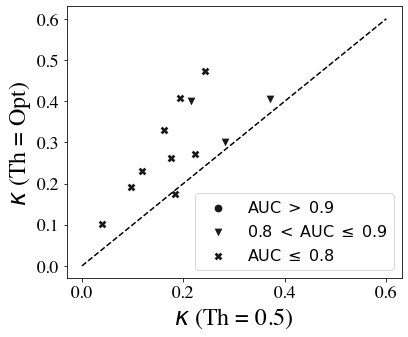

In [121]:
scatterplot_kappa2(kappa_th05_tox21, kappa_thopt_tox21, opt_thresholds_tox21, auc_tox21, output_name='Results_DeepChem_Tox21')

# MUV dataset

In [113]:
tasks_muv, datasets_muv, transformers_muv = dc.molnet.load_muv(splitter=splitter, featurizer=featurizer, reload=False)


In [114]:
model_muv, opt_thresholds_muv, auc_muv, kappa_th05_muv, kappa_thopt_muv = train_deepchem_nn(tasks_muv, datasets_muv, thresholds, featurizer=featurizer, N_epochs = 10)


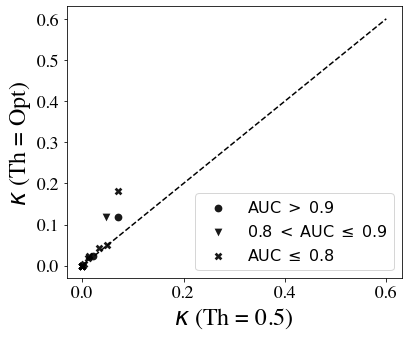

In [122]:
scatterplot_kappa2(kappa_th05_muv, kappa_thopt_muv, opt_thresholds_muv, auc_muv, output_name='Results_DeepChem_MUV')

# Pubchem datasets

In [117]:
tasks_pcba, datasets_pcba, transformers_pcba = dc.molnet.load_pcba(splitter=splitter, featurizer=featurizer, reload=False)

RDKit WARNING: [17:34:38] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:35:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:38:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:38:55] WARNING: not removing hydrogen atom without neighbors


In [118]:
model_pcba, opt_thresholds_pcba, auc_pcba, kappa_th05_pcba, kappa_thopt_pcba = train_deepchem_nn(tasks_pcba, datasets_pcba, thresholds, N_epochs = 10)


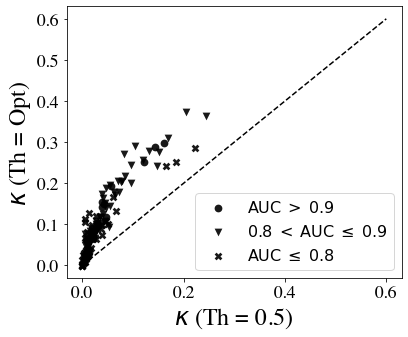

In [123]:
scatterplot_kappa2(kappa_th05_pcba, kappa_thopt_pcba, opt_thresholds_pcba, auc_pcba, output_name='Results_DeepChem_PubChem')